In [84]:
import numpy as np
import pandas as pd
import multicoil_motion_simulator
import mrimotion as mot
import models
import losses
import os
import plotting_utils
from interlacer import utils
import tensorflow as tf
import mghGErecon as ge
from matplotlib import pyplot as plt

In [2]:
base_data_dir = '/vast/kmotion/users/nmsingh/dev/ismrm2022/multicoil_data_splits_obofix'
val_dir = os.path.join(base_data_dir,'test')

dir_list = os.listdir(val_dir)
dir_list = [file for file in dir_list if file[-4:]=='.npz']


In [118]:
def sim_given_motion(ex, angle, trans, motion_shot = 2):
    scan_data = ex.split('.')[0].split('_')[:4]
    scan_data.insert(2,'recon')
    scan_data.insert(0,'/vast/kmotion/data/data_anon/data_chelsea')
    sl = int(ex.split('.')[0].split('_')[4])

    res_info = np.load(os.path.join('/'.join(scan_data),'resolutioninfo.npz'))
    psx = res_info['pixelSizeX']
    psy = res_info['pixelSizeY']
    
    scan_data = os.path.join('/'.join(scan_data))
    acq_data_path = os.path.join(scan_data,'kspace_recon.npz')
    kspace = mot.utils.load_kspace(acq_data_path, 'ge', z_shift=False)


    n_dim = len(kspace.shape)
    if(n_dim==4):
        kspace = np.expand_dims(kspace,-1)
    elif(n_dim==6):
        kspace = kspace[...,0]
    n_sl = kspace.shape[3]

    kspace_sl = kspace[:,:,:44,sl,0]
    k = kspace_sl[...,np.newaxis].transpose(0,1,3,2)
    maps = np.load(os.path.join(val_dir,ex))['maps']
    

    file_2d_acqorder = os.path.join(scan_data, 'loopcounters.npz')
    order_ky, _, _ = mot.acqorder.get_segments(file_2d_acqorder, show_plots=False)
    order_ky = [order.astype('int32')-1 for order in order_ky]

    kspace = k[:,:,0,:]
    maps = maps[:,:,0,:]
    
    
    kspace_shift = np.fft.ifftshift(kspace,axes=(0,1))
    img_slice = np.fft.fftshift(np.fft.ifftn(kspace_shift,axes=(0,1)),axes=(0,1))
    img_recon = np.sqrt(np.sum(np.square(np.abs(img_slice)), axis=2))

    n_x = kspace.shape[1]
    n_y = kspace.shape[0]

    num_motions = 1
    motion_shots = [0]
    motion_shots.extend([motion_shot])
    num_points = len(motion_shots)
    
    num_pix = np.empty((trans.shape))
    num_pix[:, 0] = trans[:, 0]/psx
    num_pix[:, 1] = trans[:, 1]/psy
    
    k_corrupt, k_true = multicoil_motion_simulator.add_rotation_and_translations(img_recon, maps, order_ky, motion_shots, angle, num_pix)

    # Split real and imaginary
    k_corrupt = np.concatenate([np.real(k_corrupt), np.imag(k_corrupt)], axis=2)
    k_true = np.concatenate([np.real(k_true), np.imag(k_true)], axis=2)

    # Add batch dimension
    k_corrupt = np.expand_dims(k_corrupt, 0)
    k_true = np.expand_dims(k_true, 0)
    
    norm = np.max(plotting_utils.rss_image_from_multicoil_k(k_corrupt[0,:,:,:]).flatten())
    v_in = k_corrupt / norm
    v_out = k_true / norm

    return v_in, v_out, scan_data

In [24]:
num_coils = 44
freq_ssim = losses.multicoil_ssim('FREQ',num_coils)

In [41]:
labels = ['Freq-Only','Image-Only','GRAPPA','Joint']
dirs = ['training/FINAL_nonlinearity/44-CONV_RESIDUAL-9-64-1-12-multicoil_ssim-FREQ-FREQ-3-piece-5000-6',
       'training/FINAL_nobn_recontinue/44-CONV_RESIDUAL-9-64-1-12-multicoil_ssim-IMAGE-IMAGE-relu-5000-6',
       '',
       'training/FINAL_interlacer_noshift/44-INTERLACER_RESIDUAL-9-64-1-6-multicoil_ssim-FREQ-FREQ-3-piece-5000-6',
       ]
epochs = [200,120,None,1850]

angle_cols = ['Example','Theta','htrans_mm','vtrans_mm','Model','Output SSIM','SSIM']
angle_results = pd.DataFrame(columns=angle_cols)

for i in range(4):
    if(i!=2):
        if(i==0):
            model = models.get_multicoil_conv_model(
                    (None, None, 2*num_coils),
                    '3-piece',
                    9,
                    64,
                    12,
                    num_coils)
        elif(i==1):
            model = models.get_multicoil_conv_model(
                    (None, None, 2*num_coils),
                    'relu',
                    9,
                    64,
                    12,
                    num_coils)
        elif(i==3):
            model = models.get_multicoil_interlacer_model(
                    (None, None, 2*num_coils),
                    '3-piece',
                    9,
                    64,
                    1,
                    6,
                    num_coils)


        lr = 1e-3
        model.compile(
            optimizer=tf.keras.optimizers.SGD(
                lr=lr),
            loss=freq_ssim,
            loss_weights=1)    

        epoch = str(epochs[i]).zfill(4)
        model.load_weights(dirs[i]+'/cp-'+epoch+'.ckpt')

    for j,ex in enumerate([dir_list[0]]):
        for angle_i in np.arange(-5,5,0.25):
            print(angle_i)
            angle = np.asarray([0,angle_i])
            horiz_trans = 0
            vert_trans = 0
            trans = np.asarray(np.zeros((2,2)))
            trans[1,0] = horiz_trans
            trans[1,1]= vert_trans
            v_in, v_out, scan_data = sim_given_motion(ex,angle,num_pix)
            
    
            if(i!=2):
                if 'Image' not in labels[i]:
                    v_model = model(v_in)
                else:
                    v_in_img = utils.convert_channels_to_image_domain(tf.convert_to_tensor(v_in))
                    v_model_img = model(v_in_img)
                    v_model = utils.convert_channels_to_frequency_domain(tf.convert_to_tensor(v_model_img))
            else:        
                v_grappa = ge.recon.recon_arc_kspace(utils.join_reim_channels(tf.convert_to_tensor(v_in))[0,...],scan_data)
                v_model = utils.split_reim_channels(tf.expand_dims(v_grappa,0))

            v_out = tf.convert_to_tensor(v_out)
            v_in = tf.convert_to_tensor(v_in)
            v_model = tf.convert_to_tensor(v_model)
            
            angle_results = angle_results.append({
                'Model': labels[i],
                'Example': ex,
                'Theta': angle_i,
                'htrans_mm': horiz_trans,
                'vtrans_mm': vert_trans,
                'Output SSIM': freq_ssim(v_out,v_model).numpy()[0],
                'SSIM':-1*freq_ssim(v_out,v_model).numpy()[0]
            },ignore_index=True)



-5.0
file only has one key: kspace_recon
  return numpy array
no kz pi phase shift applied
loaded k-space size is: (416, 300, 44, 30)
Number of:
  current_y_res = 300, ref_views = 0 
  slices = 30 
  operations = 1 
  passes = 2
pass 0:
 15 slices per TR: [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28]
 segments: 8
pass 1:
 15 slices per TR: [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29]
 segments: 8
-4.75
file only has one key: kspace_recon
  return numpy array
no kz pi phase shift applied
loaded k-space size is: (416, 300, 44, 30)
Number of:
  current_y_res = 300, ref_views = 0 
  slices = 30 
  operations = 1 
  passes = 2
pass 0:
 15 slices per TR: [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28]
 segments: 8
pass 1:
 15 slices per TR: [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29]
 segments: 8
-4.5
file only has one key: kspace_recon
  return numpy array
no kz pi phase shift applied
loaded k-space size is: (416, 300, 44, 30)
Number of:
  current_y_

0.0
file only has one key: kspace_recon
  return numpy array
no kz pi phase shift applied
loaded k-space size is: (416, 300, 44, 30)
Number of:
  current_y_res = 300, ref_views = 0 
  slices = 30 
  operations = 1 
  passes = 2
pass 0:
 15 slices per TR: [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28]
 segments: 8
pass 1:
 15 slices per TR: [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29]
 segments: 8
0.25
file only has one key: kspace_recon
  return numpy array
no kz pi phase shift applied
loaded k-space size is: (416, 300, 44, 30)
Number of:
  current_y_res = 300, ref_views = 0 
  slices = 30 
  operations = 1 
  passes = 2
pass 0:
 15 slices per TR: [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28]
 segments: 8
pass 1:
 15 slices per TR: [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29]
 segments: 8
0.5
file only has one key: kspace_recon
  return numpy array
no kz pi phase shift applied
loaded k-space size is: (416, 300, 44, 30)
Number of:
  current_y_res

-5.0
file only has one key: kspace_recon
  return numpy array
no kz pi phase shift applied
loaded k-space size is: (416, 300, 44, 30)
Number of:
  current_y_res = 300, ref_views = 0 
  slices = 30 
  operations = 1 
  passes = 2
pass 0:
 15 slices per TR: [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28]
 segments: 8
pass 1:
 15 slices per TR: [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29]
 segments: 8
-4.75
file only has one key: kspace_recon
  return numpy array
no kz pi phase shift applied
loaded k-space size is: (416, 300, 44, 30)
Number of:
  current_y_res = 300, ref_views = 0 
  slices = 30 
  operations = 1 
  passes = 2
pass 0:
 15 slices per TR: [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28]
 segments: 8
pass 1:
 15 slices per TR: [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29]
 segments: 8
-4.5
file only has one key: kspace_recon
  return numpy array
no kz pi phase shift applied
loaded k-space size is: (416, 300, 44, 30)
Number of:
  current_y_

0.0
file only has one key: kspace_recon
  return numpy array
no kz pi phase shift applied
loaded k-space size is: (416, 300, 44, 30)
Number of:
  current_y_res = 300, ref_views = 0 
  slices = 30 
  operations = 1 
  passes = 2
pass 0:
 15 slices per TR: [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28]
 segments: 8
pass 1:
 15 slices per TR: [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29]
 segments: 8
0.25
file only has one key: kspace_recon
  return numpy array
no kz pi phase shift applied
loaded k-space size is: (416, 300, 44, 30)
Number of:
  current_y_res = 300, ref_views = 0 
  slices = 30 
  operations = 1 
  passes = 2
pass 0:
 15 slices per TR: [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28]
 segments: 8
pass 1:
 15 slices per TR: [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29]
 segments: 8
0.5
file only has one key: kspace_recon
  return numpy array
no kz pi phase shift applied
loaded k-space size is: (416, 300, 44, 30)
Number of:
  current_y_res

-5.0
file only has one key: kspace_recon
  return numpy array
no kz pi phase shift applied
loaded k-space size is: (416, 300, 44, 30)
Number of:
  current_y_res = 300, ref_views = 0 
  slices = 30 
  operations = 1 
  passes = 2
pass 0:
 15 slices per TR: [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28]
 segments: 8
pass 1:
 15 slices per TR: [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29]
 segments: 8
running ARC recon, input dims: (416, 300, 44)
psdnameannot:  
psd_iname: FSE
psdname: fse-xl
pseq: 19.0
se_desc: ANONYMIZED
 ----
 sequence is 2DFSE 
 ----
target of GERecon.so symlink is:
	/vast/kmotion/code/ge-orchestra/orchestra-sdk-1.10-1/orchestra-sdk-1.10-1.python/GERecon.so.python35
orchestra_version: 	orchestra-sdk-1.10-1.python
gerecon_version: 	GERecon.so.python35
  running ARC on slice: 0
-4.75
file only has one key: kspace_recon
  return numpy array
no kz pi phase shift applied
loaded k-space size is: (416, 300, 44, 30)
Number of:
  current_y_res = 300, ref_vie

-2.5
file only has one key: kspace_recon
  return numpy array
no kz pi phase shift applied
loaded k-space size is: (416, 300, 44, 30)
Number of:
  current_y_res = 300, ref_views = 0 
  slices = 30 
  operations = 1 
  passes = 2
pass 0:
 15 slices per TR: [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28]
 segments: 8
pass 1:
 15 slices per TR: [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29]
 segments: 8
running ARC recon, input dims: (416, 300, 44)
psdnameannot:  
psd_iname: FSE
psdname: fse-xl
pseq: 19.0
se_desc: ANONYMIZED
 ----
 sequence is 2DFSE 
 ----
target of GERecon.so symlink is:
	/vast/kmotion/code/ge-orchestra/orchestra-sdk-1.10-1/orchestra-sdk-1.10-1.python/GERecon.so.python35
orchestra_version: 	orchestra-sdk-1.10-1.python
gerecon_version: 	GERecon.so.python35
  running ARC on slice: 0
-2.25
file only has one key: kspace_recon
  return numpy array
no kz pi phase shift applied
loaded k-space size is: (416, 300, 44, 30)
Number of:
  current_y_res = 300, ref_vie

0.0
file only has one key: kspace_recon
  return numpy array
no kz pi phase shift applied
loaded k-space size is: (416, 300, 44, 30)
Number of:
  current_y_res = 300, ref_views = 0 
  slices = 30 
  operations = 1 
  passes = 2
pass 0:
 15 slices per TR: [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28]
 segments: 8
pass 1:
 15 slices per TR: [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29]
 segments: 8
running ARC recon, input dims: (416, 300, 44)
psdnameannot:  
psd_iname: FSE
psdname: fse-xl
pseq: 19.0
se_desc: ANONYMIZED
 ----
 sequence is 2DFSE 
 ----
target of GERecon.so symlink is:
	/vast/kmotion/code/ge-orchestra/orchestra-sdk-1.10-1/orchestra-sdk-1.10-1.python/GERecon.so.python35
orchestra_version: 	orchestra-sdk-1.10-1.python
gerecon_version: 	GERecon.so.python35
  running ARC on slice: 0
0.25
file only has one key: kspace_recon
  return numpy array
no kz pi phase shift applied
loaded k-space size is: (416, 300, 44, 30)
Number of:
  current_y_res = 300, ref_views

2.5
file only has one key: kspace_recon
  return numpy array
no kz pi phase shift applied
loaded k-space size is: (416, 300, 44, 30)
Number of:
  current_y_res = 300, ref_views = 0 
  slices = 30 
  operations = 1 
  passes = 2
pass 0:
 15 slices per TR: [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28]
 segments: 8
pass 1:
 15 slices per TR: [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29]
 segments: 8
running ARC recon, input dims: (416, 300, 44)
psdnameannot:  
psd_iname: FSE
psdname: fse-xl
pseq: 19.0
se_desc: ANONYMIZED
 ----
 sequence is 2DFSE 
 ----
target of GERecon.so symlink is:
	/vast/kmotion/code/ge-orchestra/orchestra-sdk-1.10-1/orchestra-sdk-1.10-1.python/GERecon.so.python35
orchestra_version: 	orchestra-sdk-1.10-1.python
gerecon_version: 	GERecon.so.python35
  running ARC on slice: 0
2.75
file only has one key: kspace_recon
  return numpy array
no kz pi phase shift applied
loaded k-space size is: (416, 300, 44, 30)
Number of:
  current_y_res = 300, ref_views

-5.0
file only has one key: kspace_recon
  return numpy array
no kz pi phase shift applied
loaded k-space size is: (416, 300, 44, 30)
Number of:
  current_y_res = 300, ref_views = 0 
  slices = 30 
  operations = 1 
  passes = 2
pass 0:
 15 slices per TR: [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28]
 segments: 8
pass 1:
 15 slices per TR: [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29]
 segments: 8
-4.75
file only has one key: kspace_recon
  return numpy array
no kz pi phase shift applied
loaded k-space size is: (416, 300, 44, 30)
Number of:
  current_y_res = 300, ref_views = 0 
  slices = 30 
  operations = 1 
  passes = 2
pass 0:
 15 slices per TR: [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28]
 segments: 8
pass 1:
 15 slices per TR: [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29]
 segments: 8
-4.5
file only has one key: kspace_recon
  return numpy array
no kz pi phase shift applied
loaded k-space size is: (416, 300, 44, 30)
Number of:
  current_y_

0.0
file only has one key: kspace_recon
  return numpy array
no kz pi phase shift applied
loaded k-space size is: (416, 300, 44, 30)
Number of:
  current_y_res = 300, ref_views = 0 
  slices = 30 
  operations = 1 
  passes = 2
pass 0:
 15 slices per TR: [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28]
 segments: 8
pass 1:
 15 slices per TR: [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29]
 segments: 8
0.25
file only has one key: kspace_recon
  return numpy array
no kz pi phase shift applied
loaded k-space size is: (416, 300, 44, 30)
Number of:
  current_y_res = 300, ref_views = 0 
  slices = 30 
  operations = 1 
  passes = 2
pass 0:
 15 slices per TR: [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28]
 segments: 8
pass 1:
 15 slices per TR: [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29]
 segments: 8
0.5
file only has one key: kspace_recon
  return numpy array
no kz pi phase shift applied
loaded k-space size is: (416, 300, 44, 30)
Number of:
  current_y_res

In [42]:
angle_results.to_csv('angle_results.csv')

In [54]:
labels = ['Freq-Only','Image-Only','GRAPPA','Joint']
dirs = ['training/FINAL_nonlinearity/44-CONV_RESIDUAL-9-64-1-12-multicoil_ssim-FREQ-FREQ-3-piece-5000-6',
       'training/FINAL_nobn_recontinue/44-CONV_RESIDUAL-9-64-1-12-multicoil_ssim-IMAGE-IMAGE-relu-5000-6',
       '',
       'training/FINAL_interlacer_noshift/44-INTERLACER_RESIDUAL-9-64-1-6-multicoil_ssim-FREQ-FREQ-3-piece-5000-6',
       ]
epochs = [200,120,None,1850]

angle_cols = ['Example','Theta','htrans_mm','vtrans_mm','Model','Output SSIM','SSIM']
horiz_trans_results = pd.DataFrame(columns=angle_cols)

for i in range(4):
    if(i!=2):
        if(i==0):
            model = models.get_multicoil_conv_model(
                    (None, None, 2*num_coils),
                    '3-piece',
                    9,
                    64,
                    12,
                    num_coils)
        elif(i==1):
            model = models.get_multicoil_conv_model(
                    (None, None, 2*num_coils),
                    'relu',
                    9,
                    64,
                    12,
                    num_coils)
        elif(i==3):
            model = models.get_multicoil_interlacer_model(
                    (None, None, 2*num_coils),
                    '3-piece',
                    9,
                    64,
                    1,
                    6,
                    num_coils)


        lr = 1e-3
        model.compile(
            optimizer=tf.keras.optimizers.SGD(
                lr=lr),
            loss=freq_ssim,
            loss_weights=1)    

        epoch = str(epochs[i]).zfill(4)
        model.load_weights(dirs[i]+'/cp-'+epoch+'.ckpt')

    for j,ex in enumerate([dir_list[0]]):
        for horiz_trans_i in np.arange(-5,5,0.25):
            print(horiz_trans_i)
            angle = np.asarray([0,0])
            vert_trans = 0
            trans = np.asarray(np.zeros((2,2)))
            trans[1,0] = horiz_trans_i
            trans[1,1]= vert_trans
            v_in, v_out, scan_data = sim_given_motion(ex,angle,trans)
            
    
            if(i!=2):
                if 'Image' not in labels[i]:
                    v_model = model(v_in)
                else:
                    v_in_img = utils.convert_channels_to_image_domain(tf.convert_to_tensor(v_in))
                    v_model_img = model(v_in_img)
                    v_model = utils.convert_channels_to_frequency_domain(tf.convert_to_tensor(v_model_img))
            else:        
                v_grappa = ge.recon.recon_arc_kspace(utils.join_reim_channels(tf.convert_to_tensor(v_in))[0,...],scan_data)
                v_model = utils.split_reim_channels(tf.expand_dims(v_grappa,0))

            v_out = tf.convert_to_tensor(v_out)
            v_in = tf.convert_to_tensor(v_in)
            v_model = tf.convert_to_tensor(v_model)
            
            horiz_trans_results = horiz_trans_results.append({
                'Model': labels[i],
                'Example': ex,
                'Theta': angle,
                'htrans_mm': horiz_trans_i,
                'vtrans_mm': vert_trans,
                'Output SSIM': freq_ssim(v_out,v_model).numpy()[0],
                'SSIM':-1*freq_ssim(v_out,v_model).numpy()[0]
            },ignore_index=True)



-5.0
file only has one key: kspace_recon
  return numpy array
no kz pi phase shift applied
loaded k-space size is: (416, 300, 44, 30)
Number of:
  current_y_res = 300, ref_views = 0 
  slices = 30 
  operations = 1 
  passes = 2
pass 0:
 15 slices per TR: [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28]
 segments: 8
pass 1:
 15 slices per TR: [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29]
 segments: 8
-4.75
file only has one key: kspace_recon
  return numpy array
no kz pi phase shift applied
loaded k-space size is: (416, 300, 44, 30)
Number of:
  current_y_res = 300, ref_views = 0 
  slices = 30 
  operations = 1 
  passes = 2
pass 0:
 15 slices per TR: [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28]
 segments: 8
pass 1:
 15 slices per TR: [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29]
 segments: 8
-4.5
file only has one key: kspace_recon
  return numpy array
no kz pi phase shift applied
loaded k-space size is: (416, 300, 44, 30)
Number of:
  current_y_

0.0
file only has one key: kspace_recon
  return numpy array
no kz pi phase shift applied
loaded k-space size is: (416, 300, 44, 30)
Number of:
  current_y_res = 300, ref_views = 0 
  slices = 30 
  operations = 1 
  passes = 2
pass 0:
 15 slices per TR: [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28]
 segments: 8
pass 1:
 15 slices per TR: [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29]
 segments: 8
0.25
file only has one key: kspace_recon
  return numpy array
no kz pi phase shift applied
loaded k-space size is: (416, 300, 44, 30)
Number of:
  current_y_res = 300, ref_views = 0 
  slices = 30 
  operations = 1 
  passes = 2
pass 0:
 15 slices per TR: [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28]
 segments: 8
pass 1:
 15 slices per TR: [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29]
 segments: 8
0.5
file only has one key: kspace_recon
  return numpy array
no kz pi phase shift applied
loaded k-space size is: (416, 300, 44, 30)
Number of:
  current_y_res

-5.0
file only has one key: kspace_recon
  return numpy array
no kz pi phase shift applied
loaded k-space size is: (416, 300, 44, 30)
Number of:
  current_y_res = 300, ref_views = 0 
  slices = 30 
  operations = 1 
  passes = 2
pass 0:
 15 slices per TR: [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28]
 segments: 8
pass 1:
 15 slices per TR: [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29]
 segments: 8
-4.75
file only has one key: kspace_recon
  return numpy array
no kz pi phase shift applied
loaded k-space size is: (416, 300, 44, 30)
Number of:
  current_y_res = 300, ref_views = 0 
  slices = 30 
  operations = 1 
  passes = 2
pass 0:
 15 slices per TR: [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28]
 segments: 8
pass 1:
 15 slices per TR: [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29]
 segments: 8
-4.5
file only has one key: kspace_recon
  return numpy array
no kz pi phase shift applied
loaded k-space size is: (416, 300, 44, 30)
Number of:
  current_y_

0.0
file only has one key: kspace_recon
  return numpy array
no kz pi phase shift applied
loaded k-space size is: (416, 300, 44, 30)
Number of:
  current_y_res = 300, ref_views = 0 
  slices = 30 
  operations = 1 
  passes = 2
pass 0:
 15 slices per TR: [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28]
 segments: 8
pass 1:
 15 slices per TR: [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29]
 segments: 8
0.25
file only has one key: kspace_recon
  return numpy array
no kz pi phase shift applied
loaded k-space size is: (416, 300, 44, 30)
Number of:
  current_y_res = 300, ref_views = 0 
  slices = 30 
  operations = 1 
  passes = 2
pass 0:
 15 slices per TR: [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28]
 segments: 8
pass 1:
 15 slices per TR: [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29]
 segments: 8
0.5
file only has one key: kspace_recon
  return numpy array
no kz pi phase shift applied
loaded k-space size is: (416, 300, 44, 30)
Number of:
  current_y_res

-5.0
file only has one key: kspace_recon
  return numpy array
no kz pi phase shift applied
loaded k-space size is: (416, 300, 44, 30)
Number of:
  current_y_res = 300, ref_views = 0 
  slices = 30 
  operations = 1 
  passes = 2
pass 0:
 15 slices per TR: [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28]
 segments: 8
pass 1:
 15 slices per TR: [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29]
 segments: 8
running ARC recon, input dims: (416, 300, 44)
psdnameannot:  
psd_iname: FSE
psdname: fse-xl
pseq: 19.0
se_desc: ANONYMIZED
 ----
 sequence is 2DFSE 
 ----
target of GERecon.so symlink is:
	/vast/kmotion/code/ge-orchestra/orchestra-sdk-1.10-1/orchestra-sdk-1.10-1.python/GERecon.so.python35
orchestra_version: 	orchestra-sdk-1.10-1.python
gerecon_version: 	GERecon.so.python35
  running ARC on slice: 0
-4.75
file only has one key: kspace_recon
  return numpy array
no kz pi phase shift applied
loaded k-space size is: (416, 300, 44, 30)
Number of:
  current_y_res = 300, ref_vie

-2.5
file only has one key: kspace_recon
  return numpy array
no kz pi phase shift applied
loaded k-space size is: (416, 300, 44, 30)
Number of:
  current_y_res = 300, ref_views = 0 
  slices = 30 
  operations = 1 
  passes = 2
pass 0:
 15 slices per TR: [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28]
 segments: 8
pass 1:
 15 slices per TR: [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29]
 segments: 8
running ARC recon, input dims: (416, 300, 44)
psdnameannot:  
psd_iname: FSE
psdname: fse-xl
pseq: 19.0
se_desc: ANONYMIZED
 ----
 sequence is 2DFSE 
 ----
target of GERecon.so symlink is:
	/vast/kmotion/code/ge-orchestra/orchestra-sdk-1.10-1/orchestra-sdk-1.10-1.python/GERecon.so.python35
orchestra_version: 	orchestra-sdk-1.10-1.python
gerecon_version: 	GERecon.so.python35
  running ARC on slice: 0
-2.25
file only has one key: kspace_recon
  return numpy array
no kz pi phase shift applied
loaded k-space size is: (416, 300, 44, 30)
Number of:
  current_y_res = 300, ref_vie

0.0
file only has one key: kspace_recon
  return numpy array
no kz pi phase shift applied
loaded k-space size is: (416, 300, 44, 30)
Number of:
  current_y_res = 300, ref_views = 0 
  slices = 30 
  operations = 1 
  passes = 2
pass 0:
 15 slices per TR: [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28]
 segments: 8
pass 1:
 15 slices per TR: [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29]
 segments: 8
running ARC recon, input dims: (416, 300, 44)
psdnameannot:  
psd_iname: FSE
psdname: fse-xl
pseq: 19.0
se_desc: ANONYMIZED
 ----
 sequence is 2DFSE 
 ----
target of GERecon.so symlink is:
	/vast/kmotion/code/ge-orchestra/orchestra-sdk-1.10-1/orchestra-sdk-1.10-1.python/GERecon.so.python35
orchestra_version: 	orchestra-sdk-1.10-1.python
gerecon_version: 	GERecon.so.python35
  running ARC on slice: 0
0.25
file only has one key: kspace_recon
  return numpy array
no kz pi phase shift applied
loaded k-space size is: (416, 300, 44, 30)
Number of:
  current_y_res = 300, ref_views

2.5
file only has one key: kspace_recon
  return numpy array
no kz pi phase shift applied
loaded k-space size is: (416, 300, 44, 30)
Number of:
  current_y_res = 300, ref_views = 0 
  slices = 30 
  operations = 1 
  passes = 2
pass 0:
 15 slices per TR: [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28]
 segments: 8
pass 1:
 15 slices per TR: [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29]
 segments: 8
running ARC recon, input dims: (416, 300, 44)
psdnameannot:  
psd_iname: FSE
psdname: fse-xl
pseq: 19.0
se_desc: ANONYMIZED
 ----
 sequence is 2DFSE 
 ----
target of GERecon.so symlink is:
	/vast/kmotion/code/ge-orchestra/orchestra-sdk-1.10-1/orchestra-sdk-1.10-1.python/GERecon.so.python35
orchestra_version: 	orchestra-sdk-1.10-1.python
gerecon_version: 	GERecon.so.python35
  running ARC on slice: 0
2.75
file only has one key: kspace_recon
  return numpy array
no kz pi phase shift applied
loaded k-space size is: (416, 300, 44, 30)
Number of:
  current_y_res = 300, ref_views

-5.0
file only has one key: kspace_recon
  return numpy array
no kz pi phase shift applied
loaded k-space size is: (416, 300, 44, 30)
Number of:
  current_y_res = 300, ref_views = 0 
  slices = 30 
  operations = 1 
  passes = 2
pass 0:
 15 slices per TR: [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28]
 segments: 8
pass 1:
 15 slices per TR: [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29]
 segments: 8
-4.75
file only has one key: kspace_recon
  return numpy array
no kz pi phase shift applied
loaded k-space size is: (416, 300, 44, 30)
Number of:
  current_y_res = 300, ref_views = 0 
  slices = 30 
  operations = 1 
  passes = 2
pass 0:
 15 slices per TR: [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28]
 segments: 8
pass 1:
 15 slices per TR: [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29]
 segments: 8
-4.5
file only has one key: kspace_recon
  return numpy array
no kz pi phase shift applied
loaded k-space size is: (416, 300, 44, 30)
Number of:
  current_y_

0.0
file only has one key: kspace_recon
  return numpy array
no kz pi phase shift applied
loaded k-space size is: (416, 300, 44, 30)
Number of:
  current_y_res = 300, ref_views = 0 
  slices = 30 
  operations = 1 
  passes = 2
pass 0:
 15 slices per TR: [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28]
 segments: 8
pass 1:
 15 slices per TR: [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29]
 segments: 8
0.25
file only has one key: kspace_recon
  return numpy array
no kz pi phase shift applied
loaded k-space size is: (416, 300, 44, 30)
Number of:
  current_y_res = 300, ref_views = 0 
  slices = 30 
  operations = 1 
  passes = 2
pass 0:
 15 slices per TR: [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28]
 segments: 8
pass 1:
 15 slices per TR: [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29]
 segments: 8
0.5
file only has one key: kspace_recon
  return numpy array
no kz pi phase shift applied
loaded k-space size is: (416, 300, 44, 30)
Number of:
  current_y_res

In [55]:
horiz_trans_results.to_csv('horiz_trans_results.csv')

In [76]:
labels = ['Freq-Only','Image-Only','GRAPPA','Joint']
dirs = ['training/FINAL_nonlinearity/44-CONV_RESIDUAL-9-64-1-12-multicoil_ssim-FREQ-FREQ-3-piece-5000-6',
       'training/FINAL_nobn_recontinue/44-CONV_RESIDUAL-9-64-1-12-multicoil_ssim-IMAGE-IMAGE-relu-5000-6',
       '',
       'training/FINAL_interlacer_noshift/44-INTERLACER_RESIDUAL-9-64-1-6-multicoil_ssim-FREQ-FREQ-3-piece-5000-6',
       ]
epochs = [200,120,None,1850]

angle_cols = ['Example','Theta','htrans_mm','vtrans_mm','Model','Output SSIM','SSIM']
vert_trans_results = pd.DataFrame(columns=angle_cols)

for i in range(4):
    if(i!=2):
        if(i==0):
            model = models.get_multicoil_conv_model(
                    (None, None, 2*num_coils),
                    '3-piece',
                    9,
                    64,
                    12,
                    num_coils)
        elif(i==1):
            model = models.get_multicoil_conv_model(
                    (None, None, 2*num_coils),
                    'relu',
                    9,
                    64,
                    12,
                    num_coils)
        elif(i==3):
            model = models.get_multicoil_interlacer_model(
                    (None, None, 2*num_coils),
                    '3-piece',
                    9,
                    64,
                    1,
                    6,
                    num_coils)


        lr = 1e-3
        model.compile(
            optimizer=tf.keras.optimizers.SGD(
                lr=lr),
            loss=freq_ssim,
            loss_weights=1)    

        epoch = str(epochs[i]).zfill(4)
        model.load_weights(dirs[i]+'/cp-'+epoch+'.ckpt')

    for j,ex in enumerate([dir_list[0]]):
        for vert_trans_i in np.arange(-5,5,0.25):
            print(vert_trans_i)
            angle = np.asarray([0,0])
            horiz_trans = 0
            trans = np.asarray(np.zeros((2,2)))
            trans[1,0] = horiz_trans
            trans[1,1]= vert_trans_i
            v_in, v_out, scan_data = sim_given_motion(ex,angle,trans)
            
    
            if(i!=2):
                if 'Image' not in labels[i]:
                    v_model = model(v_in)
                else:
                    v_in_img = utils.convert_channels_to_image_domain(tf.convert_to_tensor(v_in))
                    v_model_img = model(v_in_img)
                    v_model = utils.convert_channels_to_frequency_domain(tf.convert_to_tensor(v_model_img))
            else:        
                v_grappa = ge.recon.recon_arc_kspace(utils.join_reim_channels(tf.convert_to_tensor(v_in))[0,...],scan_data)
                v_model = utils.split_reim_channels(tf.expand_dims(v_grappa,0))

            v_out = tf.convert_to_tensor(v_out)
            v_in = tf.convert_to_tensor(v_in)
            v_model = tf.convert_to_tensor(v_model)
            
            vert_trans_results = vert_trans_results.append({
                'Model': labels[i],
                'Example': ex,
                'Theta': angle,
                'htrans_mm': horiz_trans,
                'vtrans_mm': vert_trans_i,
                'Output SSIM': freq_ssim(v_out,v_model).numpy()[0],
                'SSIM':-1*freq_ssim(v_out,v_model).numpy()[0]
            },ignore_index=True)



-5.0
file only has one key: kspace_recon
  return numpy array
no kz pi phase shift applied
loaded k-space size is: (416, 300, 44, 30)
Number of:
  current_y_res = 300, ref_views = 0 
  slices = 30 
  operations = 1 
  passes = 2
pass 0:
 15 slices per TR: [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28]
 segments: 8
pass 1:
 15 slices per TR: [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29]
 segments: 8
-4.75
file only has one key: kspace_recon
  return numpy array
no kz pi phase shift applied
loaded k-space size is: (416, 300, 44, 30)
Number of:
  current_y_res = 300, ref_views = 0 
  slices = 30 
  operations = 1 
  passes = 2
pass 0:
 15 slices per TR: [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28]
 segments: 8
pass 1:
 15 slices per TR: [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29]
 segments: 8
-4.5
file only has one key: kspace_recon
  return numpy array
no kz pi phase shift applied
loaded k-space size is: (416, 300, 44, 30)
Number of:
  current_y_

0.0
file only has one key: kspace_recon
  return numpy array
no kz pi phase shift applied
loaded k-space size is: (416, 300, 44, 30)
Number of:
  current_y_res = 300, ref_views = 0 
  slices = 30 
  operations = 1 
  passes = 2
pass 0:
 15 slices per TR: [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28]
 segments: 8
pass 1:
 15 slices per TR: [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29]
 segments: 8
0.25
file only has one key: kspace_recon
  return numpy array
no kz pi phase shift applied
loaded k-space size is: (416, 300, 44, 30)
Number of:
  current_y_res = 300, ref_views = 0 
  slices = 30 
  operations = 1 
  passes = 2
pass 0:
 15 slices per TR: [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28]
 segments: 8
pass 1:
 15 slices per TR: [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29]
 segments: 8
0.5
file only has one key: kspace_recon
  return numpy array
no kz pi phase shift applied
loaded k-space size is: (416, 300, 44, 30)
Number of:
  current_y_res

-5.0
file only has one key: kspace_recon
  return numpy array
no kz pi phase shift applied
loaded k-space size is: (416, 300, 44, 30)
Number of:
  current_y_res = 300, ref_views = 0 
  slices = 30 
  operations = 1 
  passes = 2
pass 0:
 15 slices per TR: [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28]
 segments: 8
pass 1:
 15 slices per TR: [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29]
 segments: 8
-4.75
file only has one key: kspace_recon
  return numpy array
no kz pi phase shift applied
loaded k-space size is: (416, 300, 44, 30)
Number of:
  current_y_res = 300, ref_views = 0 
  slices = 30 
  operations = 1 
  passes = 2
pass 0:
 15 slices per TR: [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28]
 segments: 8
pass 1:
 15 slices per TR: [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29]
 segments: 8
-4.5
file only has one key: kspace_recon
  return numpy array
no kz pi phase shift applied
loaded k-space size is: (416, 300, 44, 30)
Number of:
  current_y_

0.0
file only has one key: kspace_recon
  return numpy array
no kz pi phase shift applied
loaded k-space size is: (416, 300, 44, 30)
Number of:
  current_y_res = 300, ref_views = 0 
  slices = 30 
  operations = 1 
  passes = 2
pass 0:
 15 slices per TR: [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28]
 segments: 8
pass 1:
 15 slices per TR: [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29]
 segments: 8
0.25
file only has one key: kspace_recon
  return numpy array
no kz pi phase shift applied
loaded k-space size is: (416, 300, 44, 30)
Number of:
  current_y_res = 300, ref_views = 0 
  slices = 30 
  operations = 1 
  passes = 2
pass 0:
 15 slices per TR: [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28]
 segments: 8
pass 1:
 15 slices per TR: [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29]
 segments: 8
0.5
file only has one key: kspace_recon
  return numpy array
no kz pi phase shift applied
loaded k-space size is: (416, 300, 44, 30)
Number of:
  current_y_res

-5.0
file only has one key: kspace_recon
  return numpy array
no kz pi phase shift applied
loaded k-space size is: (416, 300, 44, 30)
Number of:
  current_y_res = 300, ref_views = 0 
  slices = 30 
  operations = 1 
  passes = 2
pass 0:
 15 slices per TR: [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28]
 segments: 8
pass 1:
 15 slices per TR: [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29]
 segments: 8
running ARC recon, input dims: (416, 300, 44)
psdnameannot:  
psd_iname: FSE
psdname: fse-xl
pseq: 19.0
se_desc: ANONYMIZED
 ----
 sequence is 2DFSE 
 ----
target of GERecon.so symlink is:
	/vast/kmotion/code/ge-orchestra/orchestra-sdk-1.10-1/orchestra-sdk-1.10-1.python/GERecon.so.python35
orchestra_version: 	orchestra-sdk-1.10-1.python
gerecon_version: 	GERecon.so.python35
  running ARC on slice: 0
-4.75
file only has one key: kspace_recon
  return numpy array
no kz pi phase shift applied
loaded k-space size is: (416, 300, 44, 30)
Number of:
  current_y_res = 300, ref_vie

-2.5
file only has one key: kspace_recon
  return numpy array
no kz pi phase shift applied
loaded k-space size is: (416, 300, 44, 30)
Number of:
  current_y_res = 300, ref_views = 0 
  slices = 30 
  operations = 1 
  passes = 2
pass 0:
 15 slices per TR: [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28]
 segments: 8
pass 1:
 15 slices per TR: [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29]
 segments: 8
running ARC recon, input dims: (416, 300, 44)
psdnameannot:  
psd_iname: FSE
psdname: fse-xl
pseq: 19.0
se_desc: ANONYMIZED
 ----
 sequence is 2DFSE 
 ----
target of GERecon.so symlink is:
	/vast/kmotion/code/ge-orchestra/orchestra-sdk-1.10-1/orchestra-sdk-1.10-1.python/GERecon.so.python35
orchestra_version: 	orchestra-sdk-1.10-1.python
gerecon_version: 	GERecon.so.python35
  running ARC on slice: 0
-2.25
file only has one key: kspace_recon
  return numpy array
no kz pi phase shift applied
loaded k-space size is: (416, 300, 44, 30)
Number of:
  current_y_res = 300, ref_vie

0.0
file only has one key: kspace_recon
  return numpy array
no kz pi phase shift applied
loaded k-space size is: (416, 300, 44, 30)
Number of:
  current_y_res = 300, ref_views = 0 
  slices = 30 
  operations = 1 
  passes = 2
pass 0:
 15 slices per TR: [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28]
 segments: 8
pass 1:
 15 slices per TR: [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29]
 segments: 8
running ARC recon, input dims: (416, 300, 44)
psdnameannot:  
psd_iname: FSE
psdname: fse-xl
pseq: 19.0
se_desc: ANONYMIZED
 ----
 sequence is 2DFSE 
 ----
target of GERecon.so symlink is:
	/vast/kmotion/code/ge-orchestra/orchestra-sdk-1.10-1/orchestra-sdk-1.10-1.python/GERecon.so.python35
orchestra_version: 	orchestra-sdk-1.10-1.python
gerecon_version: 	GERecon.so.python35
  running ARC on slice: 0
0.25
file only has one key: kspace_recon
  return numpy array
no kz pi phase shift applied
loaded k-space size is: (416, 300, 44, 30)
Number of:
  current_y_res = 300, ref_views

2.5
file only has one key: kspace_recon
  return numpy array
no kz pi phase shift applied
loaded k-space size is: (416, 300, 44, 30)
Number of:
  current_y_res = 300, ref_views = 0 
  slices = 30 
  operations = 1 
  passes = 2
pass 0:
 15 slices per TR: [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28]
 segments: 8
pass 1:
 15 slices per TR: [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29]
 segments: 8
running ARC recon, input dims: (416, 300, 44)
psdnameannot:  
psd_iname: FSE
psdname: fse-xl
pseq: 19.0
se_desc: ANONYMIZED
 ----
 sequence is 2DFSE 
 ----
target of GERecon.so symlink is:
	/vast/kmotion/code/ge-orchestra/orchestra-sdk-1.10-1/orchestra-sdk-1.10-1.python/GERecon.so.python35
orchestra_version: 	orchestra-sdk-1.10-1.python
gerecon_version: 	GERecon.so.python35
  running ARC on slice: 0
2.75
file only has one key: kspace_recon
  return numpy array
no kz pi phase shift applied
loaded k-space size is: (416, 300, 44, 30)
Number of:
  current_y_res = 300, ref_views

-5.0
file only has one key: kspace_recon
  return numpy array
no kz pi phase shift applied
loaded k-space size is: (416, 300, 44, 30)
Number of:
  current_y_res = 300, ref_views = 0 
  slices = 30 
  operations = 1 
  passes = 2
pass 0:
 15 slices per TR: [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28]
 segments: 8
pass 1:
 15 slices per TR: [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29]
 segments: 8
-4.75
file only has one key: kspace_recon
  return numpy array
no kz pi phase shift applied
loaded k-space size is: (416, 300, 44, 30)
Number of:
  current_y_res = 300, ref_views = 0 
  slices = 30 
  operations = 1 
  passes = 2
pass 0:
 15 slices per TR: [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28]
 segments: 8
pass 1:
 15 slices per TR: [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29]
 segments: 8
-4.5
file only has one key: kspace_recon
  return numpy array
no kz pi phase shift applied
loaded k-space size is: (416, 300, 44, 30)
Number of:
  current_y_

0.0
file only has one key: kspace_recon
  return numpy array
no kz pi phase shift applied
loaded k-space size is: (416, 300, 44, 30)
Number of:
  current_y_res = 300, ref_views = 0 
  slices = 30 
  operations = 1 
  passes = 2
pass 0:
 15 slices per TR: [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28]
 segments: 8
pass 1:
 15 slices per TR: [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29]
 segments: 8
0.25
file only has one key: kspace_recon
  return numpy array
no kz pi phase shift applied
loaded k-space size is: (416, 300, 44, 30)
Number of:
  current_y_res = 300, ref_views = 0 
  slices = 30 
  operations = 1 
  passes = 2
pass 0:
 15 slices per TR: [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28]
 segments: 8
pass 1:
 15 slices per TR: [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29]
 segments: 8
0.5
file only has one key: kspace_recon
  return numpy array
no kz pi phase shift applied
loaded k-space size is: (416, 300, 44, 30)
Number of:
  current_y_res

In [69]:
-1*freq_ssim(v_out,v_model).numpy()[0]

0.7644123435020447

In [77]:
vert_trans_results.to_csv('vert_trans_results.csv')

In [71]:
scan_data = ex.split('.')[0].split('_')[:4]
scan_data.insert(2,'recon')
scan_data.insert(0,'/vast/kmotion/data/data_anon/data_chelsea')
sl = int(ex.split('.')[0].split('_')[4])

res_info = np.load(os.path.join('/'.join(scan_data),'resolutioninfo.npz'))
psx = res_info['pixelSizeX']
psy = res_info['pixelSizeY']


In [125]:
labels = ['GRAPPA','Joint']
model_dir = 'training/FINAL_interlacer_noshift/44-INTERLACER_RESIDUAL-9-64-1-6-multicoil_ssim-FREQ-FREQ-3-piece-5000-6'
model_epoch = 1850

v_ins = []
v_outs = []
v_models = []
v_grappas = []

angles = [0.25,2.5,0,0,0,0]
horiz_transes = [0,0,0.25,2.5,0,0]
vert_transes = [0,0,0,0,0.25,2.5]

model = models.get_multicoil_interlacer_model(
            (None, None, 2*num_coils),
            '3-piece',
            9,
            64,
            1,
            6,
            num_coils)

lr = 1e-3
model.compile(
    optimizer=tf.keras.optimizers.SGD(
        lr=lr),
    loss=freq_ssim,
    loss_weights=1)    

epoch = str(model_epoch).zfill(4)
model.load_weights(model_dir+'/cp-'+epoch+'.ckpt')

ex = dir_list[0]
for i in range(6):
    angle = np.asarray([0,angles[i]])
    horiz_trans = horiz_transes[i]
    vert_trans = vert_transes[i]

    trans = np.asarray(np.zeros((2,2)))
    trans[1,0] = horiz_trans
    trans[1,1]= vert_trans
    v_in, v_out, scan_data = sim_given_motion(ex,angle,trans,motion_shot=3)


    v_model = model(v_in)       
    v_grappa = ge.recon.recon_arc_kspace(utils.join_reim_channels(tf.convert_to_tensor(v_in))[0,...],scan_data)
    v_grappa = utils.split_reim_channels(tf.expand_dims(v_grappa,0))
    
    print(freq_ssim(v_model,v_out))

    v_model = utils.join_reim_channels(tf.convert_to_tensor(v_model))
    v_grappa = utils.join_reim_channels(tf.convert_to_tensor(v_grappa))

    v_ins.append(v_in)
    v_outs.append(v_out)
    v_models.append(v_model)
    v_grappas.append(v_grappa)


file only has one key: kspace_recon
  return numpy array
no kz pi phase shift applied
loaded k-space size is: (416, 300, 44, 30)
Number of:
  current_y_res = 300, ref_views = 0 
  slices = 30 
  operations = 1 
  passes = 2
pass 0:
 15 slices per TR: [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28]
 segments: 8
pass 1:
 15 slices per TR: [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29]
 segments: 8
running ARC recon, input dims: (416, 300, 44)
psdnameannot:  
psd_iname: FSE
psdname: fse-xl
pseq: 19.0
se_desc: ANONYMIZED
 ----
 sequence is 2DFSE 
 ----
target of GERecon.so symlink is:
	/vast/kmotion/code/ge-orchestra/orchestra-sdk-1.10-1/orchestra-sdk-1.10-1.python/GERecon.so.python35
orchestra_version: 	orchestra-sdk-1.10-1.python
gerecon_version: 	GERecon.so.python35
  running ARC on slice: 0
tf.Tensor([-0.9422383], shape=(1,), dtype=float32)
file only has one key: kspace_recon
  return numpy array
no kz pi phase shift applied
loaded k-space size is: (416, 300, 44, 30)
N

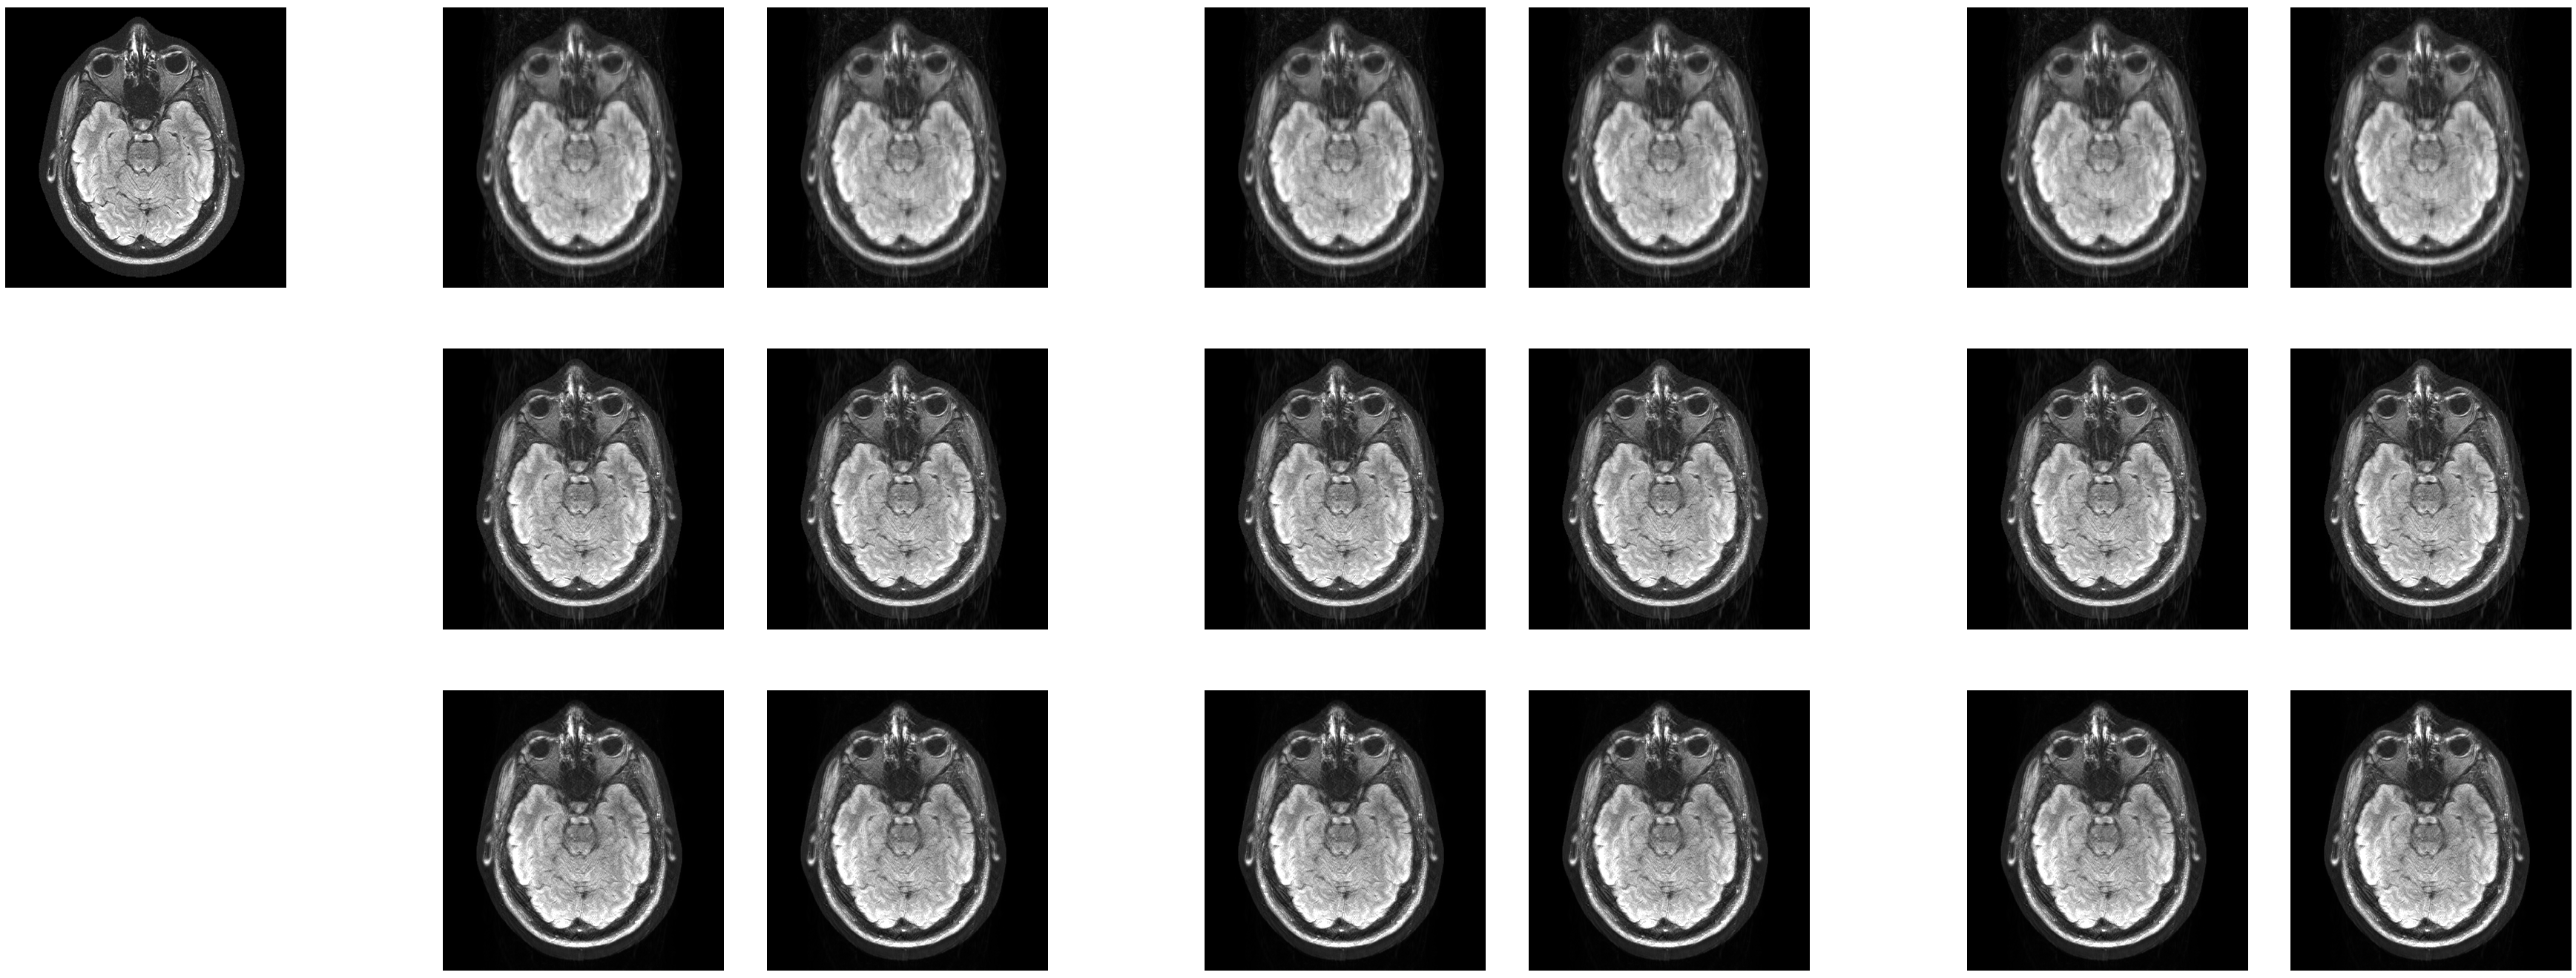

In [135]:
fig = plt.figure(figsize=(62,24))
gs = fig.add_gridspec(3, 10, width_ratios=[1,0.25,1,1,0.25,1,1,0.25,1,1])

axes = []
axes.append(fig.add_subplot(gs[0,0]))

space = fig.add_subplot(gs[0,1:])
space.axis('off')

space = fig.add_subplot(gs[1,:])
space.axis('off')

for i in range(2,10):
    if(i%3!=1):
        for j in range(3):
            axes.append(fig.add_subplot(gs[j,i]))
    else:
        space = fig.add_subplot(gs[:,i])
        space.axis('off')
        
plotting_utils.plot_img_from_k(utils.join_reim_channels(tf.convert_to_tensor(v_out))[0,...],axes=axes[0],psx=psx,psy=psy)

for i in range(1,19):
    for j in range(6):
        if(i%3==1):
            plotting_utils.plot_img_from_k(utils.join_reim_channels(tf.convert_to_tensor(v_ins[j]))[0,...],axes=axes[i],psx=psx,psy=psy)
        elif(i%3==2):
            plotting_utils.plot_img_from_k(v_grappas[j][0,...],axes=axes[i],psx=psx,psy=psy)
        elif(i%3==0):
            plotting_utils.plot_img_from_k(v_models[j][0,...],axes=axes[i],psx=psx,psy=psy)



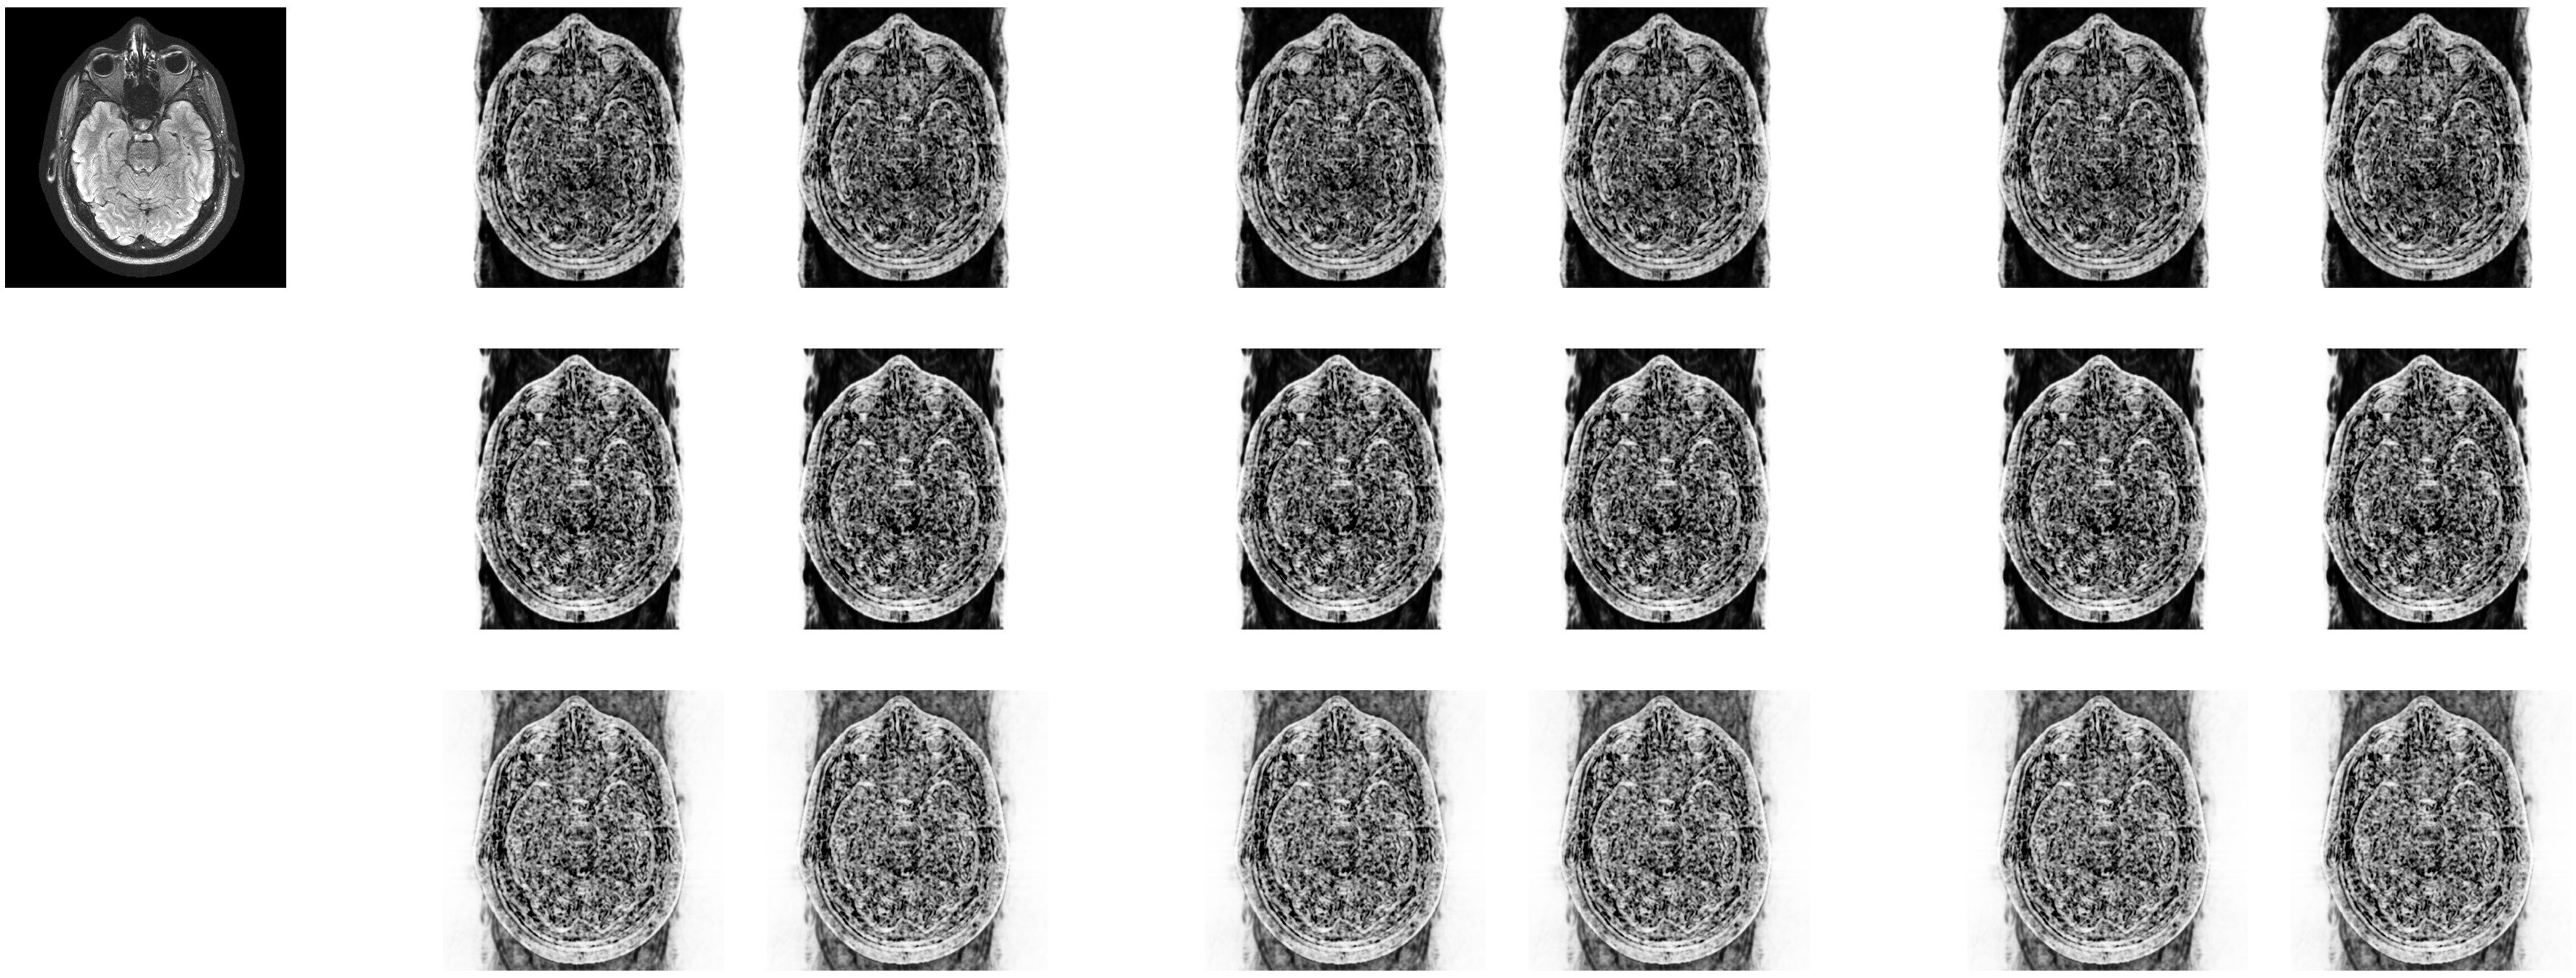

In [136]:
fig = plt.figure(figsize=(62,24))
gs = fig.add_gridspec(3, 10, width_ratios=[1,0.25,1,1,0.25,1,1,0.25,1,1])

axes = []
axes.append(fig.add_subplot(gs[0,0]))

space = fig.add_subplot(gs[0,1:])
space.axis('off')

space = fig.add_subplot(gs[1,:])
space.axis('off')

for i in range(2,10):
    if(i%3!=1):
        for j in range(3):
            axes.append(fig.add_subplot(gs[j,i]))
    else:
        space = fig.add_subplot(gs[:,i])
        space.axis('off')

v_out_joined = utils.join_reim_channels(tf.convert_to_tensor(v_out))[0,...]
plotting_utils.plot_img_from_k(v_out_joined,axes=axes[0],psx=psx,psy=psy)

for i in range(1,19):
    for j in range(6):
        if(i%3==1):
            plotting_utils.plot_img_ssim_from_k(utils.join_reim_channels(tf.convert_to_tensor(v_ins[j]))[0,...],v_out_joined,axes=axes[i],psx=psx,psy=psy)
        elif(i%3==2):
            plotting_utils.plot_img_ssim_from_k(v_grappas[j][0,...],v_out_joined,axes=axes[i],psx=psx,psy=psy)
        elif(i%3==0):
            plotting_utils.plot_img_ssim_from_k(v_models[j][0,...],v_out_joined,axes=axes[i],psx=psx,psy=psy)



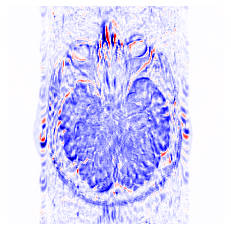

In [139]:
plotting_utils.plot_img_diff_from_k(utils.join_reim_channels(tf.convert_to_tensor(v_ins[0]))[0,...],utils.join_reim_channels(tf.convert_to_tensor(v_ins[1]))[0,...],psx=psx,psy=psy)

In [134]:
v.shape_in

NameError: name 'v' is not defined